## Beta-2 adrenergic receptor - part 4 (library enumeration)

### Import libraries

In [1]:
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

from rdkit import Chem

### Read in the datasets

In [2]:
df = pd.read_csv('beta2_agonists_stripped.csv')
df_trans = pd.read_csv('beta2_agonists_transformations.csv')

### Take adrenaline as only seed

In [3]:
df = df[df.stripped_smiles=='CNC[C@H](O)c1ccc(O)c(O)c1']

### Merge on assay identifier to enumerate all seed molecule / transformation pairs

In [4]:
df = df[pd.notna(df.pchembl_value)]

### Apply the transformations

In [5]:
def apply_reaction(smiles, smirks):
    rxn = Chem.rdChemReactions.ReactionFromSmarts(smirks)
    productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(smiles)),))
    productlist = list()
    for product in productset:
        productlist.append('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
    return list(set(productlist))

### Generate 1st generation products

In [6]:
df = df.merge(df_trans, on=['target_pref_name', 'standard_type'])
df_seed_1 = df.progress_apply(lambda x: apply_reaction(x.stripped_smiles, x.smirks), axis=1)

100%|██████████| 6890/6890 [00:03<00:00, 1877.43it/s]


In [7]:
df_seed_1 = df.join(pd.DataFrame(df_seed_1.explode(), columns=['products']))
df_seed_1 = df_seed_1[pd.notna(df_seed_1.products)]

In [8]:
df_seed_1['pchembl_predicted'] = df_seed_1.pchembl_value + df_seed_1.mean_pchembl_exact_delta
df_seed_1 = pd.pivot_table(df_seed_1, values=['pchembl_predicted'], index=['stripped_smiles',
    'products', 'radius', 'target_pref_name', 'standard_type'], aggfunc='mean').reset_index()

### Generate 2nd generation products

In [9]:
df_seed_1 = df_seed_1.merge(df_trans, on=['target_pref_name', 'standard_type'], suffixes=['', '_2'])
df_seed_2 = df_seed_1.progress_apply(lambda x: apply_reaction(x.products, x.smirks), axis=1)

100%|██████████| 22321/22321 [00:18<00:00, 1208.67it/s]


In [10]:
df_seed_2 = df_seed_1.join(pd.DataFrame(df_seed_2.explode(), columns=['products_2']))
df_seed_2 = df_seed_2[pd.notna(df_seed_2.products_2)]

In [11]:
df_seed_2['pchembl_predicted_2'] = df_seed_2.pchembl_predicted + df_seed_2.mean_pchembl_exact_delta
df_seed_2 = pd.pivot_table(df_seed_2, values=['pchembl_predicted_2'], index=['stripped_smiles',
    'products', 'products_2', 'radius', 'radius_2', 'target_pref_name', 'standard_type'], aggfunc='mean').reset_index()

### Generate 3rd generation products

In [12]:
df_seed_2 = df_seed_2.merge(df_trans, on=['target_pref_name', 'standard_type'], suffixes=['', '_3'])
df_seed_3 = df_seed_2.progress_apply(lambda x: apply_reaction(x.products_2, x.smirks), axis=1)

100%|██████████| 221868/221868 [03:25<00:00, 1081.57it/s]


In [13]:
df_seed_3 = df_seed_2.join(pd.DataFrame(df_seed_3.explode(), columns=['products_3']))
df_seed_3 = df_seed_3[pd.notna(df_seed_3.products_3)]

In [14]:
df_seed_3['pchembl_predicted_3'] = df_seed_3.pchembl_predicted_2 + df_seed_3.mean_pchembl_exact_delta
df_products = pd.pivot_table(df_seed_3, values=['pchembl_predicted_3'], index=['stripped_smiles',
    'products', 'products_2', 'products_3', 'radius', 'radius_2', 'radius_3', 'target_pref_name', 'standard_type'], aggfunc='mean').reset_index()

### Write to file

In [15]:
df_products = df_products.reset_index()
df_products.to_csv('beta2_agonists_products.csv', index=False)

### ... and finaly tabulate

In [16]:
df_holdout = pd.read_csv('beta2_agonists_stripped_holdout.csv')
df_holdout = df_products[df_products.products_3.isin(df_holdout.stripped_smiles)]

In [17]:
df_holdout

,index,stripped_smiles,products,products_2,products_3,radius,radius_2,radius_3,target_pref_name,standard_type,pchembl_predicted_3
15,15,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(N)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,Kd,5.900000
32,32,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,Kd,5.024444
47,47,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)cc1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,Kd,6.030000
142,142,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(CO)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,Kd,5.024444
170,170,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,EC50,8.377998
171,171,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,Ki,5.358000
172,172,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Thyroid stimulating hormone receptor,Potency,6.042857
366,366,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc2ccccc2c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Thyroid stimulating hormone receptor,Potency,6.114286
1559,1559,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NC[C@@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,EC50,6.809080
1560,1560,CNC[C@H](O)c1ccc(O)c(O)c1,CC(C)NC[C@@H](O)c1ccc(O)c(O)c1,CC(C)NCC(O)c1ccc(O)c(O)c1,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,3,3,3,Beta-2 adrenergic receptor,Ki,5.987667


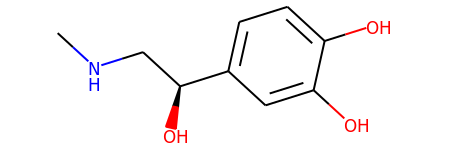

In [18]:
Chem.MolFromSmiles('CNC[C@H](O)c1ccc(O)c(O)c1')

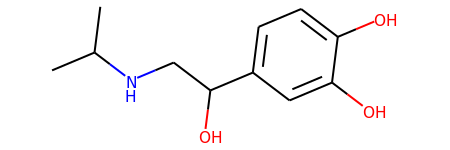

In [22]:
Chem.MolFromSmiles('CC(C)NCC(O)c1ccc(O)c(O)c1')

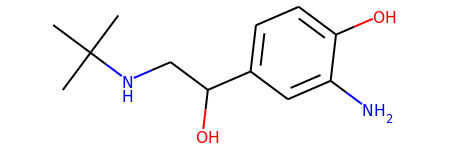

In [23]:
Chem.MolFromSmiles('CC(C)(C)NCC(O)c1ccc(O)c(N)c1')

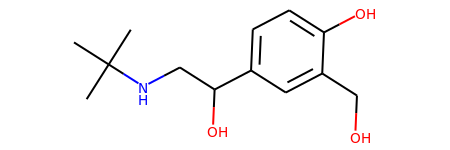

In [21]:
Chem.MolFromSmiles('CC(C)(C)NCC(O)c1ccc(O)c(CO)c1')